In [101]:
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
from tensorflow.examples.tutorials.mnist import input_data

import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image

from datasets import MNISTDataset
from time import time

%matplotlib inline

## This works!

In [63]:
tf.reset_default_graph()

tb_dir = 'summaries/itworks'

# get the data
mnist = MNISTDataset("mnist_data", batch_size=256, seed=int(time()))

# define the model first, from input to output
imgs = tf.placeholder(tf.float32, shape=[None, 28*28])

n_hidden = 100
n_layers = 8
w_range = 0.1
hidden = imgs

for layer in range(n_layers):
    name = "hidden_{}".format(layer)
    hidden = tf.layers.dense(hidden, n_hidden, activation=tf.nn.relu,
                             #kernel_initializer=tf.random_uniform_initializer(minval=-w_range, maxval=w_range),
                             kernel_initializer=tf.contrib.layers.xavier_initializer(
                                 uniform=True),
                             bias_initializer=tf.constant_initializer(0.01), name=name)
    tf.summary.histogram(name + "_hist", hidden)
logits = tf.layers.dense(hidden, 10, kernel_initializer=tf.random_uniform_initializer(minval=-w_range, maxval=w_range),
                         bias_initializer=tf.zeros_initializer, name="logits")


# create the cost and a single training step based on that
labels = tf.placeholder(tf.uint8, [None])
labels_onehot = tf.one_hot(indices=labels, depth=10)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels_onehot, logits=logits))
tf.summary.scalar("cost", cross_entropy)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.03)
for g, v in optimizer.compute_gradients(cross_entropy):
    if 'kernel' in v.name:
        tf.summary.scalar("grad_{}".format(v.name.replace(':','_')), tf.norm(g))
train_step = optimizer.minimize(cross_entropy)


# evaluation measures
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_onehot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar("accuracy", accuracy)
merged = tf.summary.merge_all()

# train!
with tf.Session() as sess:
    writer = tf.summary.FileWriter(tb_dir, sess.graph)

    sess.run(tf.global_variables_initializer())
    for step in range(1000):
        batch_xs, batch_ys = mnist.next_batch()
        stats, _ = sess.run([merged, train_step], feed_dict={imgs: batch_xs, labels: batch_ys})
        writer.add_summary(stats, step)
        if step % 100 == 0:
            train_acc, _ = sess.run([accuracy, cross_entropy], feed_dict={imgs: batch_xs, labels: batch_ys})
            print("Training accuracy on the {}th step: {}".format(step, train_acc))

    # now evaluate
    print("Final test accuracy: {}".format(sess.run([accuracy, cross_entropy],
                                                    feed_dict={imgs: mnist.test_data, labels: mnist.test_labels})))

Training accuracy on the 0th step: 0.140625
Training accuracy on the 100th step: 0.828125
Training accuracy on the 200th step: 0.88671875
Starting new epoch...
Training accuracy on the 300th step: 0.84765625
Training accuracy on the 400th step: 0.9453125
Starting new epoch...
Training accuracy on the 500th step: 0.97265625
Training accuracy on the 600th step: 0.96875
Training accuracy on the 700th step: 0.95703125
Starting new epoch...
Training accuracy on the 800th step: 0.97265625
Training accuracy on the 900th step: 0.98828125
Starting new epoch...
Final test accuracy: [0.94750017, 0.17990339]


## Failure 1

In [64]:
tf.reset_default_graph() 
tb_dir = 'summaries/ex1'

# get the data
mnist = MNISTDataset("mnist_data", batch_size=256, seed=int(time()))


# define the model first, from input to output
imgs = tf.placeholder(tf.float32, shape=[None, 28*28])

n_hidden = 100
n_layers = 8
w_range = 0.15
hidden = imgs
for layer in range(n_layers):
    name = 'hidden_{}'.format(layer)
    hidden = tf.layers.dense(
            hidden, n_hidden, activation=tf.nn.relu,
            kernel_initializer=tf.random_uniform_initializer(minval=-w_range, maxval=w_range),
            bias_initializer=tf.constant_initializer(0.01), name=name)
    with tf.name_scope('hidden'+str(layer)) as scope:
        tf.summary.histogram(name, hidden)

logits = tf.layers.dense(hidden, 10,
        kernel_initializer=tf.random_uniform_initializer(minval=-w_range, maxval=w_range),
        bias_initializer=tf.zeros_initializer, name="logits")


# create the cost and a single training step based on that
labels = tf.placeholder(tf.uint8, [None])
labels_onehot = tf.one_hot(indices=labels, depth=10)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels_onehot, logits=logits))
tf.summary.scalar("cost", cross_entropy)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
for g, v in optimizer.compute_gradients(cross_entropy):
    tf.summary.scalar("grad_{}".format(v.name.replace(':','_')), tf.norm(g))
train_step = optimizer.minimize(cross_entropy)


# evaluation measures
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_onehot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar("accuracy", accuracy)
merged = tf.summary.merge_all()

# train!
with tf.Session() as sess:
    writer = tf.summary.FileWriter(tb_dir, sess.graph)

    sess.run(tf.global_variables_initializer())
    for step in range(1000):
        batch_xs, batch_ys = mnist.next_batch()
        stats, _ = sess.run([merged, train_step], feed_dict={imgs: batch_xs, labels: batch_ys})
        writer.add_summary(stats, step)
        if step % 100 == 0:
            train_acc = sess.run([accuracy, cross_entropy], feed_dict={imgs: batch_xs, labels: batch_ys})
            print("Training accuracy on the {}th step: {}".format(step, train_acc))

    # now evaluate
    print("Final test accuracy: {}".format(sess.run([accuracy, cross_entropy],
                                                    feed_dict={imgs: mnist.test_data, labels: mnist.test_labels})))


INFO:tensorflow:Summary name grad_hidden_0/kernel:0 is illegal; using grad_hidden_0/kernel_0 instead.


INFO:tensorflow:Summary name grad_hidden_0/kernel:0 is illegal; using grad_hidden_0/kernel_0 instead.


INFO:tensorflow:Summary name grad_hidden_0/bias:0 is illegal; using grad_hidden_0/bias_0 instead.


INFO:tensorflow:Summary name grad_hidden_0/bias:0 is illegal; using grad_hidden_0/bias_0 instead.


INFO:tensorflow:Summary name grad_hidden_1/kernel:0 is illegal; using grad_hidden_1/kernel_0 instead.


INFO:tensorflow:Summary name grad_hidden_1/kernel:0 is illegal; using grad_hidden_1/kernel_0 instead.


INFO:tensorflow:Summary name grad_hidden_1/bias:0 is illegal; using grad_hidden_1/bias_0 instead.


INFO:tensorflow:Summary name grad_hidden_1/bias:0 is illegal; using grad_hidden_1/bias_0 instead.


INFO:tensorflow:Summary name grad_hidden_2/kernel:0 is illegal; using grad_hidden_2/kernel_0 instead.


INFO:tensorflow:Summary name grad_hidden_2/kernel:0 is illegal; using grad_hidden_2/kernel_0 instead.


INFO:tensorflow:Summary name grad_hidden_2/bias:0 is illegal; using grad_hidden_2/bias_0 instead.


INFO:tensorflow:Summary name grad_hidden_2/bias:0 is illegal; using grad_hidden_2/bias_0 instead.


INFO:tensorflow:Summary name grad_hidden_3/kernel:0 is illegal; using grad_hidden_3/kernel_0 instead.


INFO:tensorflow:Summary name grad_hidden_3/kernel:0 is illegal; using grad_hidden_3/kernel_0 instead.


INFO:tensorflow:Summary name grad_hidden_3/bias:0 is illegal; using grad_hidden_3/bias_0 instead.


INFO:tensorflow:Summary name grad_hidden_3/bias:0 is illegal; using grad_hidden_3/bias_0 instead.


INFO:tensorflow:Summary name grad_hidden_4/kernel:0 is illegal; using grad_hidden_4/kernel_0 instead.


INFO:tensorflow:Summary name grad_hidden_4/kernel:0 is illegal; using grad_hidden_4/kernel_0 instead.


INFO:tensorflow:Summary name grad_hidden_4/bias:0 is illegal; using grad_hidden_4/bias_0 instead.


INFO:tensorflow:Summary name grad_hidden_4/bias:0 is illegal; using grad_hidden_4/bias_0 instead.


INFO:tensorflow:Summary name grad_hidden_5/kernel:0 is illegal; using grad_hidden_5/kernel_0 instead.


INFO:tensorflow:Summary name grad_hidden_5/kernel:0 is illegal; using grad_hidden_5/kernel_0 instead.


INFO:tensorflow:Summary name grad_hidden_5/bias:0 is illegal; using grad_hidden_5/bias_0 instead.


INFO:tensorflow:Summary name grad_hidden_5/bias:0 is illegal; using grad_hidden_5/bias_0 instead.


INFO:tensorflow:Summary name grad_hidden_6/kernel:0 is illegal; using grad_hidden_6/kernel_0 instead.


INFO:tensorflow:Summary name grad_hidden_6/kernel:0 is illegal; using grad_hidden_6/kernel_0 instead.


INFO:tensorflow:Summary name grad_hidden_6/bias:0 is illegal; using grad_hidden_6/bias_0 instead.


INFO:tensorflow:Summary name grad_hidden_6/bias:0 is illegal; using grad_hidden_6/bias_0 instead.


INFO:tensorflow:Summary name grad_hidden_7/kernel:0 is illegal; using grad_hidden_7/kernel_0 instead.


INFO:tensorflow:Summary name grad_hidden_7/kernel:0 is illegal; using grad_hidden_7/kernel_0 instead.


INFO:tensorflow:Summary name grad_hidden_7/bias:0 is illegal; using grad_hidden_7/bias_0 instead.


INFO:tensorflow:Summary name grad_hidden_7/bias:0 is illegal; using grad_hidden_7/bias_0 instead.


INFO:tensorflow:Summary name grad_logits/kernel:0 is illegal; using grad_logits/kernel_0 instead.


INFO:tensorflow:Summary name grad_logits/kernel:0 is illegal; using grad_logits/kernel_0 instead.


INFO:tensorflow:Summary name grad_logits/bias:0 is illegal; using grad_logits/bias_0 instead.


INFO:tensorflow:Summary name grad_logits/bias:0 is illegal; using grad_logits/bias_0 instead.


Training accuracy on the 0th step: [0.13671875, 182.54266]


InvalidArgumentError: Infinity in summary histogram for: hidden3/hidden_3
	 [[Node: hidden3/hidden_3 = HistogramSummary[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](hidden3/hidden_3/tag, hidden_3/Relu/_73)]]

Caused by op 'hidden3/hidden_3', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-64-7cb14f620324>", line 22, in <module>
    tf.summary.histogram(name, hidden)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/summary/summary.py", line 192, in histogram
    tag=tag, values=values, name=scope)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_logging_ops.py", line 129, in _histogram_summary
    name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Infinity in summary histogram for: hidden3/hidden_3
	 [[Node: hidden3/hidden_3 = HistogramSummary[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](hidden3/hidden_3/tag, hidden_3/Relu/_73)]]


## Failure 2

In [ ]:
tf.reset_default_graph()
tb_dir = 'summaries/ex2'

# get the data
mnist = MNISTDataset("mnist_data", batch_size=256, seed=int(time()))

# define the model first, from input to output
imgs = tf.placeholder(tf.float32, shape=[None, 28*28])

n_hidden = 100
n_layers = 8
w_range = 0.1
hidden = imgs
for layer in range(n_layers):
    name = "hidden_{}".format(layer)
    with tf.name_scope(name) as scope:
        hidden = tf.layers.dense(hidden, n_hidden, activation=tf.nn.sigmoid,
                                 kernel_initializer=tf.random_uniform_initializer(minval=-w_range, maxval=w_range),
                                 bias_initializer=tf.zeros_initializer, name=name)
        tf.summary.histogram("histogram", hidden)
logits = tf.layers.dense(hidden, 10, kernel_initializer=tf.random_uniform_initializer(minval=-w_range, maxval=w_range),
                         bias_initializer=tf.zeros_initializer, name="logits")


# create the cost and a single training step based on that
labels = tf.placeholder(tf.uint8, [None])
labels_onehot = tf.one_hot(indices=labels, depth=10)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels_onehot, logits=logits))
tf.summary.scalar("cost", cross_entropy)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.03)
for g, v in optimizer.compute_gradients(cross_entropy):
    if 'kernel' in v.name:
        tf.summary.scalar("grad_{}".format(v.name), tf.norm(g))
train_step = optimizer.minimize(cross_entropy)


# evaluation measures
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_onehot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar("accuracy", accuracy)
merged = tf.summary.merge_all()

# train!
with tf.Session() as sess:
    writer = tf.summary.FileWriter(tb_dir, sess.graph)

    sess.run(tf.global_variables_initializer())
    for step in range(1000):
        batch_xs, batch_ys = mnist.next_batch()
        stats, _ = sess.run([merged, train_step], feed_dict={imgs: batch_xs, labels: batch_ys})
        writer.add_summary(stats, step)
        if step % 100 == 0:
            train_acc = sess.run([accuracy, cross_entropy], feed_dict={imgs: batch_xs, labels: batch_ys})
            print("Training accuracy on the {}th step: {}".format(step, train_acc))

    # now evaluate
    print("Final test accuracy: {}".format(sess.run([accuracy, cross_entropy],
                                                    feed_dict={imgs: mnist.test_data, labels: mnist.test_labels})))

In [50]:
def s(x):
    return np.power(1. + np.exp(-x), -1.)

def ds(x):
    return s(x)*(1.-s(x))

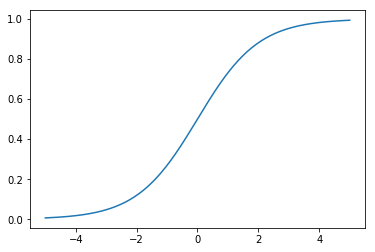

In [55]:
xs = np.linspace(-5, 5, 200)
plt.plot(xs, s(xs))
# plt.plot(xs, ds(xs), 'r')
plt.show()

## Failure 3

In [65]:
tf.reset_default_graph()
tb_dir = 'summaries/ex3'

# get the data
mnist = MNISTDataset("mnist_data", batch_size=256, seed=int(time()))


# define the model first, from input to output
imgs = tf.placeholder(tf.float32, shape=[None, 28*28])

hidden1 = tf.layers.dense(imgs, 100, activation=tf.nn.relu,
                          kernel_initializer=tf.random_uniform_initializer(minval=-0.01, maxval=0.01),
                          bias_initializer=tf.constant_initializer(0.01), name="hidden1")
hidden2 = tf.layers.dense(hidden1, 100, activation=tf.nn.relu,
                          kernel_initializer=tf.random_uniform_initializer(minval=-0.01, maxval=0.00),
                          bias_initializer=tf.constant_initializer(0.01), name="hidden2")


logits = tf.layers.dense(hidden2, 10, kernel_initializer=tf.random_uniform_initializer(minval=-0.01, maxval=0.01),
                         bias_initializer=tf.zeros_initializer, name="logits")

tf.summary.histogram('hidden1', hidden1)
tf.summary.histogram('hidden2', hidden2)

# create the cost and a single training step based on that
labels = tf.placeholder(tf.uint8, [None])
labels_onehot = tf.one_hot(indices=labels, depth=10)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels_onehot, logits=logits))
tf.summary.scalar("cost", cross_entropy)

optimizer = tf.train.AdamOptimizer()
for g, v in optimizer.compute_gradients(cross_entropy):
    if 'kernel' in v.name:
        tf.summary.scalar("grad_{}".format(v.name.replace(':','_')), tf.norm(g))
train_step = optimizer.minimize(cross_entropy)


# evaluation measures
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_onehot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar("accuracy", accuracy)
merged = tf.summary.merge_all()

# train!
with tf.Session() as sess:
    writer = tf.summary.FileWriter(tb_dir, sess.graph)

    sess.run(tf.global_variables_initializer())
    for step in range(1000):
        batch_xs, batch_ys = mnist.next_batch()
        stats, _ = sess.run([merged, train_step], feed_dict={imgs: batch_xs, labels: batch_ys})
        writer.add_summary(stats, step)
        if step % 100 == 0:
            train_acc = sess.run([accuracy, cross_entropy], feed_dict={imgs: batch_xs, labels: batch_ys})
            print("Training accuracy on the {}th step: {}".format(step, train_acc))

    # now evaluate
    print("Final test accuracy: {}".format(sess.run([accuracy, cross_entropy],
                                                    feed_dict={imgs: mnist.test_data, labels: mnist.test_labels})))


Training accuracy on the 0th step: [0.1328125, 2.3024108]
Training accuracy on the 100th step: [0.14453125, 2.2994375]
Training accuracy on the 200th step: [0.09765625, 2.3022189]
Starting new epoch...
Training accuracy on the 300th step: [0.10546875, 2.3013077]
Training accuracy on the 400th step: [0.12109375, 2.2966061]
Starting new epoch...
Training accuracy on the 500th step: [0.12890625, 2.3025215]
Training accuracy on the 600th step: [0.12890625, 2.2965834]
Training accuracy on the 700th step: [0.1015625, 2.3049922]
Starting new epoch...
Training accuracy on the 800th step: [0.1171875, 2.2996244]
Training accuracy on the 900th step: [0.0703125, 2.3059671]
Starting new epoch...
Final test accuracy: [0.11350001, 2.3010006]


## Embeddings

In [120]:
def make_sprite(imgs, out_path):
    """
    imgs: 2D (!) numpy array containing MNIST image data (i.e. 784-length vectors).
    out_path: Path to store sprite image at (e.g. path/to/file.png).
    """
    imgs_square = imgs.reshape(-1, 28, 28)
    grid_dim = int(np.ceil(np.sqrt(len(imgs))))
    grid_rows = [np.concatenate(imgs_square[ind:(ind+grid_dim)], axis=1) for ind in range(0, len(imgs), grid_dim)]
    # maybe pad last row
    missing = grid_rows[0].shape[1] - grid_rows[-1].shape[1]
    if missing:
        grid_rows[-1] = np.pad(grid_rows[-1], ((0, 0), (0, missing)), mode="constant")
    grid = np.concatenate(grid_rows, axis=0)
    # note that the images are reversed (black on white background) for readability
    image.imsave(out_path, grid, cmap="Greys")

In [121]:
tf.reset_default_graph()

tb_dir = 'summaries/embeddings_orig'

# get the data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# define the model first, from input to output
imgs = tf.placeholder(tf.float32, shape=[None, 28*28])


n_hidden = 100
n_layers = 8
w_range = 0.1
hidden = imgs
num_to_viz = 256

for layer in range(n_layers):
    name = "hidden_{}".format(layer)
    hidden = tf.layers.dense(hidden, n_hidden, activation=tf.nn.relu,
                             kernel_initializer=tf.contrib.layers.xavier_initializer(
                                 uniform=True),
                             bias_initializer=tf.constant_initializer(0.01), name=name)
    tf.summary.histogram(name + "_hist", hidden)
logits = tf.layers.dense(hidden, 10, kernel_initializer=tf.random_uniform_initializer(minval=-w_range, maxval=w_range),
                         bias_initializer=tf.zeros_initializer, name="logits")

# embedding
orig_embedding_vec = tf.Variable([0.], name='orig_embedding')
save_orig_embeddings = tf.assign(orig_embedding_vec, imgs, validate_shape=False)

embedding_vec = tf.Variable([0.], name='embedding')
save_embeddings = tf.assign(embedding_vec, hidden, validate_shape=False)

# create the cost and a single training step based on that
labels = tf.placeholder(tf.uint8, [None])
labels_onehot = tf.one_hot(indices=labels, depth=10)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels_onehot, logits=logits))
tf.summary.scalar("cost", cross_entropy)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.03)
for g, v in optimizer.compute_gradients(cross_entropy):
    if 'kernel' in v.name:
        tf.summary.scalar("grad_{}".format(v.name.replace(':','_')), tf.norm(g))
train_step = optimizer.minimize(cross_entropy)


# evaluation measures
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_onehot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar("accuracy", accuracy)
merged = tf.summary.merge_all()

saver = tf.train.Saver()

# train!
with tf.Session() as sess:
    writer = tf.summary.FileWriter(tb_dir, sess.graph)
    
    config = projector.ProjectorConfig()
    embedding_conf = config.embeddings.add()
    embedding_conf.tensor_name = orig_embedding_vec.name
    embedding_conf.metadata_path = 'metadata.tsv'
    embedding_conf.sprite.image_path = 'sprite.jpg'
    embedding_conf.sprite.single_image_dim.extend([28, 28])
    projector.visualize_embeddings(writer, config)

    test_xs, test_ys = mnist.test.images, mnist.test.labels

    sess.run(tf.global_variables_initializer())
    for step in range(1000):
        batch_xs, batch_ys = mnist.train.next_batch(1000)
        stats, _ = sess.run([merged, train_step], feed_dict={imgs: batch_xs, labels_onehot: batch_ys})
        writer.add_summary(stats, step)
        if step % 100 == 0:
            train_acc, _ = sess.run([accuracy, cross_entropy], feed_dict={imgs: batch_xs, labels_onehot: batch_ys})
            print("Training accuracy on the {}th step: {}".format(step, train_acc))
    
    sess.run([save_orig_embeddings], feed_dict={imgs: test_xs[:num_to_viz, :],
                                           labels_onehot: test_ys[:num_to_viz, :]})
    saver.save(sess, os.path.join(tb_dir, "model.ckpt"))

    # now evaluate
    print("Final test accuracy: {}".format(sess.run([accuracy, cross_entropy],
                                                    feed_dict={imgs: test_xs, labels_onehot: test_ys})))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Training accuracy on the 0th step: 0.1159999892115593
Training accuracy on the 100th step: 0.12999999523162842
Training accuracy on the 200th step: 0.2369999885559082
Training accuracy on the 300th step: 0.4490000009536743
Training accuracy on the 400th step: 0.7330000400543213
Training accuracy on the 500th step: 0.8340000510215759
Training accuracy on the 600th step: 0.843999981880188
Training accuracy on the 700th step: 0.9020000100135803
Training accuracy on the 800th step: 0.8969999551773071
Training accuracy on the 900th step: 0.9119999408721924
Final test accuracy: [0.92090011, 0.25431779]


In [122]:
# save labels as metadata
with open(os.path.join(tb_dir, 'metadata.tsv'), 'w') as fout:
    for label in list(np.where(test_ys==1)[1][:num_to_viz]):
        fout.write('{}\n'.format(label))         
        
make_sprite(test_xs[:num_to_viz, :], os.path.join(tb_dir, 'sprite.jpg'))

In [118]:
tf.reset_default_graph()

tb_dir = 'summaries/embeddings'

# get the data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# define the model first, from input to output
imgs = tf.placeholder(tf.float32, shape=[None, 28*28])


n_hidden = 100
n_layers = 8
w_range = 0.1
hidden = imgs
num_to_viz = 256

for layer in range(n_layers):
    name = "hidden_{}".format(layer)
    hidden = tf.layers.dense(hidden, n_hidden, activation=tf.nn.relu,
                             kernel_initializer=tf.contrib.layers.xavier_initializer(
                                 uniform=True),
                             bias_initializer=tf.constant_initializer(0.01), name=name)
    tf.summary.histogram(name + "_hist", hidden)
logits = tf.layers.dense(hidden, 10, kernel_initializer=tf.random_uniform_initializer(minval=-w_range, maxval=w_range),
                         bias_initializer=tf.zeros_initializer, name="logits")

# embedding
#orig_embedding_vec = tf.Variable([0.], name='orig_embedding')
#save_orig_embeddings = tf.assign(orig_embedding_vec, imgs, validate_shape=False)

embedding_vec = tf.Variable([0.], name='embedding')
save_embeddings = tf.assign(embedding_vec, hidden, validate_shape=False)

# create the cost and a single training step based on that
labels = tf.placeholder(tf.uint8, [None])
labels_onehot = tf.one_hot(indices=labels, depth=10)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels_onehot, logits=logits))
tf.summary.scalar("cost", cross_entropy)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.03)
for g, v in optimizer.compute_gradients(cross_entropy):
    if 'kernel' in v.name:
        tf.summary.scalar("grad_{}".format(v.name.replace(':','_')), tf.norm(g))
train_step = optimizer.minimize(cross_entropy)


# evaluation measures
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_onehot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar("accuracy", accuracy)
merged = tf.summary.merge_all()

saver = tf.train.Saver()

# train!
with tf.Session() as sess:
    writer = tf.summary.FileWriter(tb_dir, sess.graph)
    
    config = projector.ProjectorConfig()
    embedding_conf = config.embeddings.add()
    embedding_conf.tensor_name = embedding_vec.name
    embedding_conf.metadata_path = 'metadata.tsv'
    embedding_conf.sprite.image_path = 'sprite.jpg'
    embedding_conf.sprite.single_image_dim.extend([28, 28])
    projector.visualize_embeddings(writer, config)

    test_xs, test_ys = mnist.test.images, mnist.test.labels

    sess.run(tf.global_variables_initializer())
    for step in range(1000):
        batch_xs, batch_ys = mnist.train.next_batch(1000)
        stats, _ = sess.run([merged, train_step], feed_dict={imgs: batch_xs, labels_onehot: batch_ys})
        writer.add_summary(stats, step)
        if step % 100 == 0:
            train_acc, _ = sess.run([accuracy, cross_entropy], feed_dict={imgs: batch_xs, labels_onehot: batch_ys})
            print("Training accuracy on the {}th step: {}".format(step, train_acc))
    
    sess.run([save_embeddings], feed_dict={imgs: test_xs[:num_to_viz, :],
                                           labels_onehot: test_ys[:num_to_viz, :]})
    saver.save(sess, os.path.join(tb_dir, "model.ckpt"))

    # now evaluate
    print("Final test accuracy: {}".format(sess.run([accuracy, cross_entropy],
                                                    feed_dict={imgs: test_xs, labels_onehot: test_ys})))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Training accuracy on the 0th step: 0.09200000017881393
Training accuracy on the 100th step: 0.1810000091791153
Training accuracy on the 200th step: 0.27799999713897705
Training accuracy on the 300th step: 0.3439999520778656
Training accuracy on the 400th step: 0.687000036239624
Training accuracy on the 500th step: 0.8159999847412109
Training accuracy on the 600th step: 0.859000027179718
Training accuracy on the 700th step: 0.9039999842643738
Training accuracy on the 800th step: 0.9039999842643738
Training accuracy on the 900th step: 0.9080000519752502
Final test accuracy: [0.92160016, 0.26218414]


In [119]:
# save labels as metadata
with open(os.path.join(tb_dir, 'metadata.tsv'), 'w') as fout:
    for label in list(np.where(test_ys==1)[1][:num_to_viz]):
        fout.write('{}\n'.format(label))         
        
make_sprite(test_xs[:num_to_viz, :], os.path.join(tb_dir, 'sprite.jpg'))